In [6]:
import numpy as np
import matplotlib.pyplot as plt
import os,sys,caffe
%matplotlib inline

caffe_root='/home/Shengping/caffe/'
os.chdir(caffe_root)
sys.path.insert(0,caffe_root+'python')

plt.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# matplotlib图标正常显示中文

为了在图表中能够显示中文和负号等，需要下面一段设置：

import matplotlib.pyplot as plt

plt.rcParams['font.sas-serig']=['SimHei'] #用来正常显示中文标签

plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

# rc=run configuration


设置网络模型，并显示该模型中各层名称和参数的规模（注意此处是net.params, 而不是net.blobs)

In [7]:
net = caffe.Net(caffe_root + 'examples/cifar10/cifar10_full.prototxt',
                caffe_root + 'examples/cifar10/cifar10_quick_iter_4000.caffemodel',
                caffe.TEST)
[(k, v[0].data.shape) for k, v in net.params.items()]

RuntimeError: Could not open file /home/Shengping/caffe/examples/cifar10/ifar10_quick_iter_4000.caffemodel

In [4]:
#编写一个函数，用于显示各层的参数
def show_feature(data, padsize=1, padval=0):
    data -= data.min()
    data /= data.max()
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, padsize), (0, padsize)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=(padval, padval))
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    plt.imshow(data)
    plt.axis('off')

In [5]:
# 第一个卷积层，参数规模为(32,3,5,5)，即32个5*5的3通道filter
weight = net.params["conv1"][0].data
print weight.shape
show_feature(weight.transpose(0, 2, 3, 1))

NameError: name 'net' is not defined

参数有两种类型：权值参数和偏置项。分别用params["conv1"][0] 和params["conv1"][1] 表示 。

我们只显示权值参数，因此用params["conv1"][0] 

In [8]:
#加载必要的库
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys,os,caffe

In [9]:
#设置当前目录，判断模型是否训练好
caffe_root = '/home/Shengping/caffe/' 
sys.path.insert(0, caffe_root + 'python')
os.chdir(caffe_root)
if not os.path.isfile(caffe_root + 'examples/cifar10/cifar10_quick_iter_4000.caffemodel'):
    print("caffemodel is not exist...")

In [10]:
#利用提前训练好的模型，设置测试网络
caffe.set_mode_gpu()
net = caffe.Net(caffe_root + 'examples/cifar10/cifar10_quick.prototxt',
                caffe_root + 'examples/cifar10/cifar10_quick_iter_4000.caffemodel',
                caffe.TEST)

In [11]:
net.blobs['data'].data.shape

(1, 3, 32, 32)

(360, 480, 3)


(-0.5, 479.5, 359.5, -0.5)

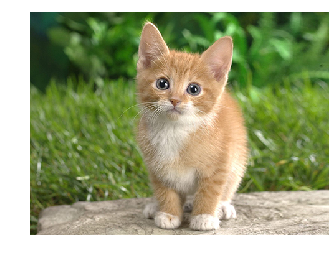

In [13]:
#加载测试图片，并显示
im = caffe.io.load_image('examples/images/cat.jpg')
print im.shape
plt.imshow(im)
plt.axis('off')

In [14]:
#　编写一个函数，将二进制的均值转换为python的均值
def convert_mean(binMean,npyMean):
    blob = caffe.proto.caffe_pb2.BlobProto()
    bin_mean = open(binMean, 'rb' ).read()
    blob.ParseFromString(bin_mean)
    arr = np.array( caffe.io.blobproto_to_array(blob) )
    npy_mean = arr[0]
    np.save(npyMean, npy_mean )
binMean=caffe_root+'examples/cifar10/mean.binaryproto'
npyMean=caffe_root+'examples/cifar10/mean.npy'
convert_mean(binMean,npyMean)

In [15]:
#将图片载入blob中,并减去均值
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_transpose('data', (2,0,1))
transformer.set_mean('data', np.load(npyMean).mean(1).mean(1)) # 减去均值
transformer.set_raw_scale('data', 255)  
transformer.set_channel_swap('data', (2,1,0))
net.blobs['data'].data[...] = transformer.preprocess('data',im)
inputData=net.blobs['data'].data

(-0.5, 31.5, 31.5, -0.5)

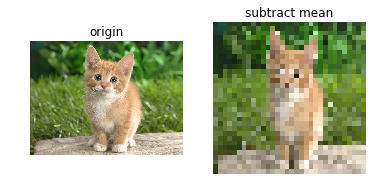

In [16]:
#显示减去均值前后的数据
plt.figure()
plt.subplot(1,2,1),plt.title("origin")
plt.imshow(im)
plt.axis('off')
plt.subplot(1,2,2),plt.title("subtract mean")
plt.imshow(transformer.deprocess('data', inputData[0]))
plt.axis('off')

In [17]:
#运行测试模型，并显示各层数据信息
net.forward()
[(k, v.data.shape) for k, v in net.blobs.items()]

[('data', (1, 3, 32, 32)),
 ('conv1', (1, 32, 32, 32)),
 ('pool1', (1, 32, 16, 16)),
 ('conv2', (1, 32, 16, 16)),
 ('pool2', (1, 32, 8, 8)),
 ('conv3', (1, 64, 8, 8)),
 ('pool3', (1, 64, 4, 4)),
 ('ip1', (1, 64)),
 ('ip2', (1, 10)),
 ('prob', (1, 10))]

In [18]:
#显示各层的参数信息
[(k, v[0].data.shape) for k, v in net.params.items()]

[('conv1', (32, 3, 5, 5)),
 ('conv2', (32, 32, 5, 5)),
 ('conv3', (64, 32, 5, 5)),
 ('ip1', (64, 1024)),
 ('ip2', (10, 64))]

In [19]:
#　编写一个函数，用于显示各层数据
def show_data(data, padsize=1, padval=0):
    data -= data.min()
    data /= data.max()
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, padsize), (0, padsize)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=(padval, padval))
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    plt.figure()
    plt.imshow(data,cmap='gray')
    plt.axis('off')
plt.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# np.pad()

## 对一维数组的填充
```
import numpy as np
arr1D = np.array([1, 1, 2, 2, 3, 4])
'''不同的填充方法'''
print 'constant:  ' + str(np.pad(arr1D, (2, 3), 'constant'))
print 'edge:  ' + str(np.pad(arr1D, (2, 3), 'edge'))
print 'linear_ramp:  ' + str(np.pad(arr1D, (2, 3), 'linear_ramp'))
print 'maximum:  ' + str(np.pad(arr1D, (2, 3), 'maximum'))
print 'mean:  ' + str(np.pad(arr1D, (2, 3), 'mean'))
print 'median:  ' + str(np.pad(arr1D, (2, 3), 'median'))
print 'minimum:  ' + str(np.pad(arr1D, (2, 3), 'minimum'))
print 'reflect:  ' + str(np.pad(arr1D, (2, 3), 'reflect'))
print 'symmetric:  ' + str(np.pad(arr1D, (2, 3), 'symmetric'))
print 'wrap:  ' + str(np.pad(arr1D, (2, 3), 'wrap'))
```
这里写图片描述

解释：

第一个参数是待填充数组

第二个参数是填充的形状，（2，3）表示前面两个，后面三个

第三个参数是填充的方法

填充方法：

constant连续一样的值填充，有关于其填充值的参数。constant_values=（x, y）时前面用x填充，后面用y填充。缺参数是为0000。。。

edge用边缘值填充

linear_ramp边缘递减的填充方式

maximum, mean, median, minimum分别用最大值、均值、中位数和最小值填充

reflect, symmetric都是对称填充。前一个是关于边缘对称，后一个是关于边缘外的空气对称╮(╯▽╰)╭

wrap用原数组后面的值填充前面，前面的值填充后面

也可以有其他自定义的填充方法

## 对多维数组的填充
import numpy as np
arr3D = np.array([[[1, 1, 2, 2, 3, 4], [1, 1, 2, 2, 3, 4], [1, 1, 2, 2, 3, 4]], 
                  [[0, 1, 2, 3, 4, 5], [0, 1, 2, 3, 4, 5], [0, 1, 2, 3, 4, 5]], 
                  [[1, 1, 2, 2, 3, 4], [1, 1, 2, 2, 3, 4], [1, 1, 2, 2, 3, 4]]])
                  '''对于多维数组'''
print 'constant:  \n' + str(np.pad(arr3D, ((0, 0), (1, 1), (2, 2)), 'constant'))
print 'edge:  \n' + str(np.pad(arr3D, ((0, 0), (1, 1), (2, 2)), 'edge'))
print 'linear_ramp:  \n' + str(np.pad(arr3D, ((0, 0), (1, 1), (2, 2)), 'linear_ramp'))
print 'maximum:  \n' + str(np.pad(arr3D, ((0, 0), (1, 1), (2, 2)), 'maximum'))
print 'mean:  \n' + str(np.pad(arr3D, ((0, 0), (1, 1), (2, 2)), 'mean'))
print 'median:  \n' + str(np.pad(arr3D, ((0, 0), (1, 1), (2, 2)), 'median'))
print 'minimum:  \n' + str(np.pad(arr3D, ((0, 0), (1, 1), (2, 2)), 'minimum'))
print 'reflect:  \n' + str(np.pad(arr3D, ((0, 0), (1, 1), (2, 2)), 'reflect'))
print 'symmetric:  \n' + str(np.pad(arr3D, ((0, 0), (1, 1), (2, 2)), 'symmetric'))
print 'wrap:  \n' + str(np.pad(arr3D, ((0, 0), (1, 1), (2, 2)), 'wrap'))
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
这里写图片描述这里写图片描述这里写图片描述这里写图片描述这里写图片描述这里写图片描述这里写图片描述这里写图片描述这里写图片描述这里写图片描述

(1, 32, 32, 32)
(32, 3, 5, 5)


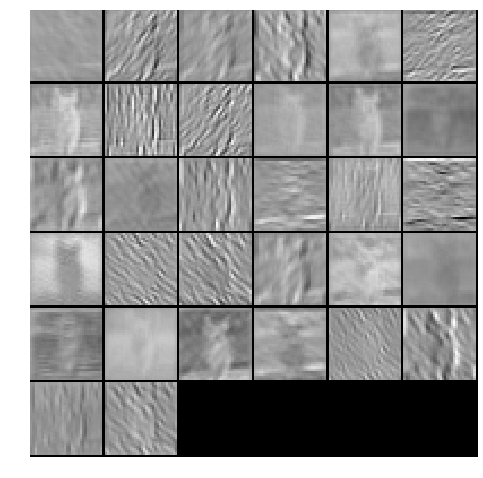

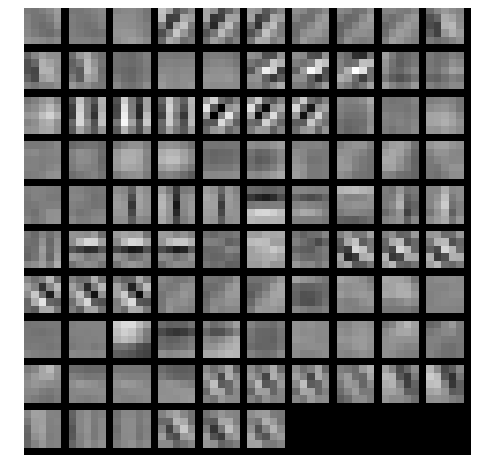

In [20]:
#显示第一个卷积层的输出数据和权值（filter）
show_data(net.blobs['conv1'].data[0])
print net.blobs['conv1'].data.shape
show_data(net.params['conv1'][0].data.reshape(32*3,5,5))
print net.params['conv1'][0].data.shape

(1, 32, 16, 16)
(32, 32, 5, 5)


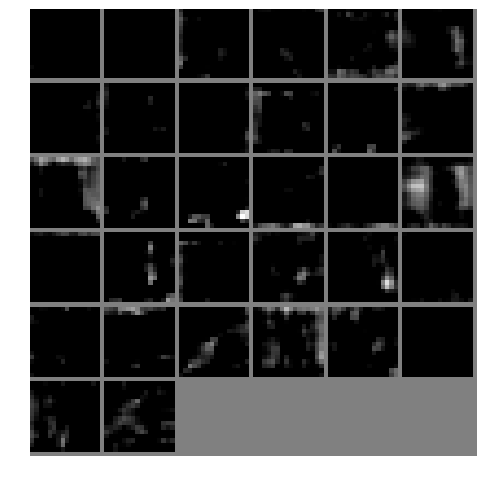

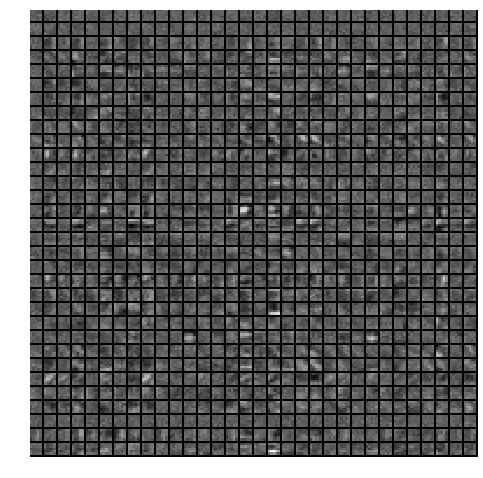

In [21]:
#显示第二次卷积后的输出数据以及相应的权值（filter）
show_data(net.blobs['conv2'].data[0],padval=0.5)
print net.blobs['conv2'].data.shape
show_data(net.params['conv2'][0].data.reshape(32**2,5,5))
print net.params['conv2'][0].data.shape

(1, 64, 8, 8)
(64, 32, 5, 5)


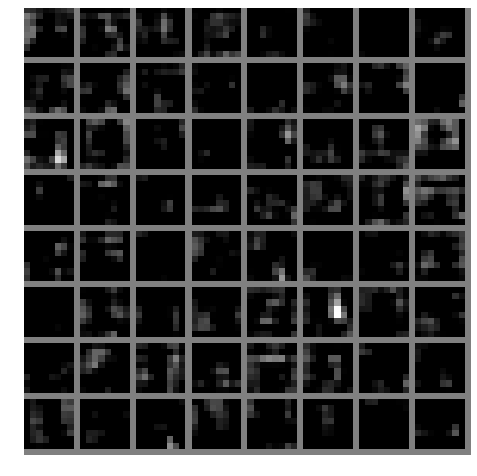

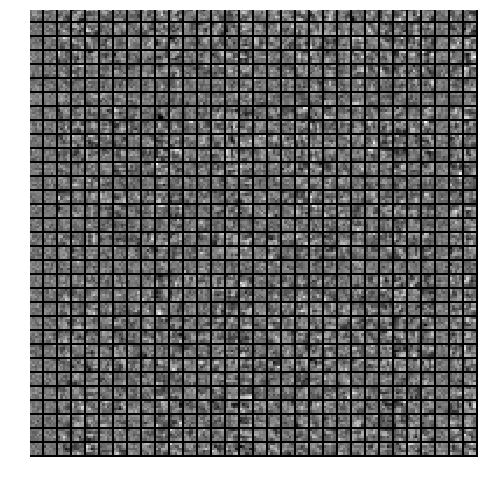

In [22]:
#显示第三次卷积后的输出数据以及相应的权值（filter）,取前１024个进行显示
show_data(net.blobs['conv3'].data[0],padval=0.5)
print net.blobs['conv3'].data.shape
show_data(net.params['conv3'][0].data.reshape(64*32,5,5)[:1024])
print net.params['conv3'][0].data.shape

(1, 64, 4, 4)


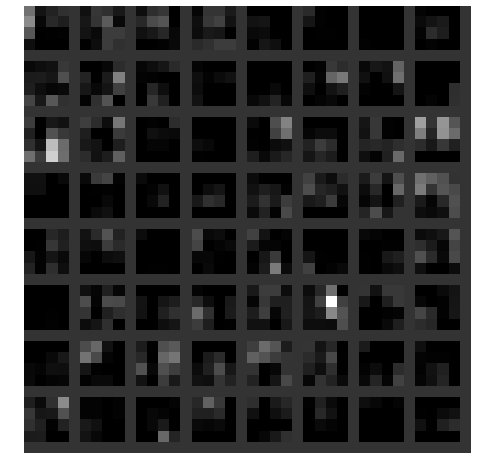

In [23]:
#显示第三次池化后的输出数据
show_data(net.blobs['pool3'].data[0],padval=0.2)
print net.blobs['pool3'].data.shape

[  1.24609168e-03   5.80914857e-05   7.97026530e-02   3.28807719e-02
   8.19062769e-01   4.86922227e-02   2.74700648e-03   1.51083162e-02
   8.80841526e-06   4.93320520e-04]


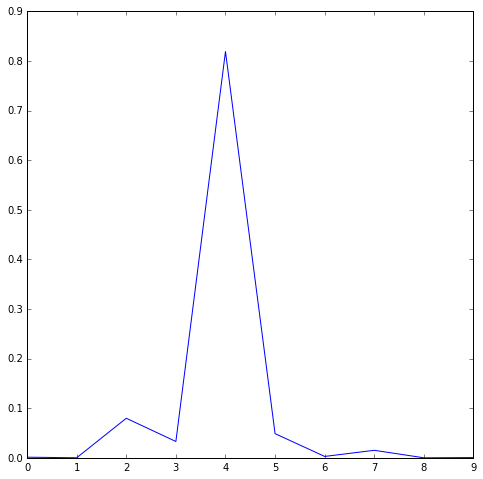

In [24]:
# 最后一层输入属于某个类的概率
feat = net.blobs['prob'].data[0]
print feat
plt.plot(feat.flat)

从输入的结果和图示来看，最大的概率是7.17785358e-01，属于第4类（标号从０开始）。与cifar10中的10种类型名称进行对比：

airplane、automobile、bird、cat、deer、dog、frog、horse、ship、truck

根据测试结果，判断为cat。 测试无误！